In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.stats import levy_stable
import scipy

# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [2]:
def npdensity1(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def npdensity2(z):
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

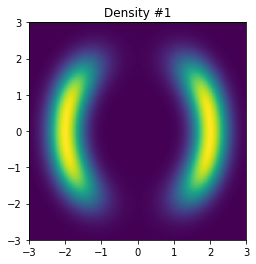

In [3]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

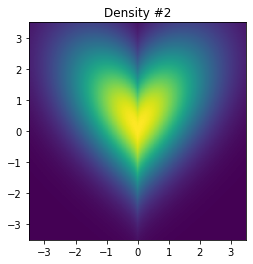

In [4]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz.

In [5]:
def potential1(z):
    z = z.view(-1, 2).double()
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

def potential2(z):
    z = z.view(-1, 2).double()
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return u

def density1(z):

    return torch.exp(-potential1(z))

def density2(z):

    return torch.exp(-potential2(z))

$$
f_{\pi}(x) \triangleq-\phi(x) \partial_{x} U(x)
$$

In [6]:
def f_pi(x, potential, density):
    x.requires_grad_()
    U = potential(x)
    grad = torch.autograd.grad(U, x)[0]
    return - density(x) * grad

$$
g_{\gamma, k} \triangleq(-1)^{k} \Gamma(\gamma+1) /\left(\Gamma\left(\frac{\gamma}{2}-k+1\right) \Gamma\left(\frac{\gamma}{2}+k+1\right)\right)
$$


In [7]:
from scipy.special import gamma as gamma_func
def g(gamma, k):
    return (-1) ** k * gamma_func(gamma + 1) / ((gamma_func(gamma/2 - k + 1)) * (gamma_func(gamma/2 + k + 1)))


$$
\Delta_{h, K}^{\gamma} f(x) \triangleq\left(1 / h^{\gamma}\right) \sum_{k=-K}^{K} g_{\gamma, k} f(x-k h)
$$

In [9]:
def fractional_centered_difference(f, x, gamma, h, K):
    sum = 0
    for k in range(-K, K+1):
        sum += g(gamma, k) * f(x - k * h)
    return (1 / (h ** gamma)) * sum



$$
b(x, \alpha) \approx \tilde{b}_{h, K}(x, \alpha) \triangleq\left(\Delta_{h, K}^{\alpha-2} f_{\pi}(x)\right) / \phi(x)
$$

In [28]:
def tilde_b(f_pi_, h, K, x, alpha, density):
    return fractional_centered_difference(f_pi_, x, alpha-2, h, K) / density(x)
    # return fractional_centered_difference(f_pi_, x, 0, h, K) / density(x)

$$
\tilde{X}_{n+1}=\tilde{X}_{n}+\eta_{n+1} \tilde{b}_{h, K}\left(\tilde{X}_{n}, \alpha\right)+\eta_{n+1}^{1 / \alpha} \Delta L_{n+1}^{\alpha}
$$

In [52]:
def fractional_approx_LMC(potential, density, alpha=1.7, n_samples=5000, steps=0.01, dim=2):
    burn_in = 5000
    X0 = torch.randn(1, dim).double()

    if type(steps) is float:
        steps = [steps] * (n_samples + burn_in)

    random_vars = levy_stable.rvs(alpha, 0, size=dim * (n_samples + burn_in))
    random_vars = torch.from_numpy(random_vars.reshape((random_vars.shape[0] // dim, dim)))

    Xi = X0
    samples = []

    for i in tqdm(range(n_samples + burn_in)):
        f_pi_ = lambda X: f_pi(X, potential, density)
        b = tilde_b(f_pi_, h=0.06, K=15, x=Xi, alpha=alpha, density=density)

        Xi = Xi.detach() + steps[i] * b + steps[i] ** (1./alpha) * random_vars[i]
        # Xi = Xi.detach() + steps[i] * b + steps[i] ** (1./alpha) * torch.randn(1, dim)
        samples.append(Xi.detach().numpy())

    return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

In [67]:
# not working properly when alpha < 2
samples1 = fractional_approx_LMC(potential1, density1, n_samples =10000, alpha=1.7, steps=0.05)
samples2 = fractional_approx_LMC(potential2, density2, n_samples =10000, alpha=1.7, steps=0.05)

indices = ~np.logical_or(np.isnan(samples1)[:, 0], np.isnan(samples1)[:, 1])
samples1 = samples1[indices]

indices = ~np.logical_or(np.isnan(samples2)[:, 0], np.isnan(samples2)[:, 1])
samples2 = samples2[indices]

samples1.shape, samples2.shape

/var/folders/57/s8ftltw13n1dfhbmr5fqsggw0000gn/T/ipykernel_3847/1462427648.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

((10000, 2), (10000, 2))

In [68]:
for i in range(0, len(samples1), 100):
    print(samples1[i])

[ 2.14732022 -0.7072871 ]
[ 2.15696569 -0.62467862]
[1.90237809 0.61930137]
[ 1.88609104 -0.01268438]
[ 1.97837816 -0.56604409]
[1.78432507 0.27739693]
[1.85190344 0.43606468]
[ 2.04613845 -0.25001508]
[ 1.5472876  -1.34449231]
[2.20970097 0.77931525]
[2.10513749 0.40545004]
[1.44258981 1.09305187]
[2.0704271  0.06550954]
[ 2.0258138  -0.46940636]
[2.11511751 0.04768208]
[2.02649065 0.60379739]
[ 2.14367107 -0.09181282]
[2.26678061 0.34458425]
[1.82448626 0.45940275]
[ 2.01482156 -1.08249495]
[ 2.22751864 -0.51838688]
[ 2.08474319 -0.5895984 ]
[ 1.81606564 -0.80792444]
[ 1.72096676 -1.69566442]
[1.27883949 1.6204999 ]
[1.62592544 1.5839459 ]
[2.17028716 0.07934995]
[ 1.87593873 -0.74854181]
[ 2.03925768 -0.81921556]
[ 0.91323691 -2.10597589]
[ 1.9320507 -0.1924168]
[2.13752316 0.21077246]
[ 2.14308295 -0.35596387]
[1.84528284 1.51031153]
[1.67659436 0.10453031]
[ 1.81919427 -0.34711772]
[1.52263095 1.39227438]
[ 1.82639538 -0.22747299]
[ 1.88018756 -0.35238917]
[1.60613565 0.83057247]


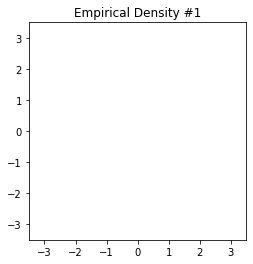

In [65]:
# not stable
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #1')
plt.show()

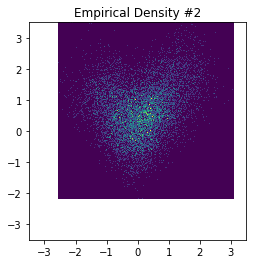

In [66]:
# not stable
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Experiemnt on paper

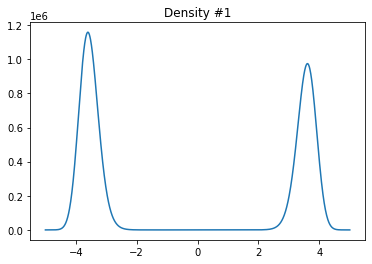

In [22]:
def npdensity3(x):
    assert(type(x) == float or type(x) == np.ndarray)
    u = (x+5) * (x+1) * (x-1.02) * (x-5) / 10 + 0.5
    return np.exp(-u)

x = np.linspace(-5, 5, 1000)

y = npdensity3(x)
plt.plot(x, y)
plt.title('Density #1')
plt.show()

In [23]:
def potential3(x):
    u = (x+5) * (x+1) * (x-1.02) * (x-5) / 10 + 0.5
    return u

def density3(x):
    return torch.exp(-potential3(x))

In [44]:
samples1 = fractional_approx_LMC(potential3, density3, alpha=1.7, steps=0.0001, dim=1)
# samples2 = fractional_approx_LMC(potential3, density3, alpha=2, steps=0.01, dim=1)

/var/folders/57/s8ftltw13n1dfhbmr5fqsggw0000gn/T/ipykernel_3847/2532938683.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
for i in range(0, len(samples1), 100):
    print(samples1[i]) # need to be between -4 and 4

[-3.52401628]
[-3.49819147]
[-3.38986147]
[-3.42696248]
[-3.53686638]
[-3.50780114]
[-3.63093354]
[-3.46804637]
[-3.43300419]
[-3.27840737]
[-3.36897639]
[-3.44082952]
[-3.48064461]
[-3.47045043]
[-3.49547889]
[-3.51203328]
[-3.54997703]
[-3.50683039]
[-3.50854222]
[-3.48383733]
[-3.70817631]
[-3.73863444]
[-3.750988]
[-3.82160838]
[-3.69491994]
[-3.82509748]
[-3.78266123]
[-3.89451072]
[-3.79195808]
[-3.8469372]
[-3.72702682]
[-3.74624637]
[-3.76322042]
[-3.80646553]
[-3.76524661]
[-3.85882479]
[-3.95118895]
[-3.92866786]
[-3.8680365]
[-3.7738294]
[-3.78820758]
[-3.82448149]
[-3.82393633]
[-3.88768434]
[-3.86286751]
[-3.76125735]
[-3.81896236]
[-3.74437225]
[-3.66936833]
[-3.60851891]


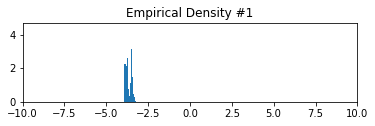

In [46]:
plt.hist(samples1, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.title('Empirical Density #1')
plt.show()

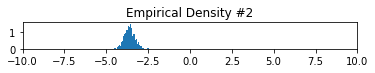

In [43]:
plt.hist(samples2, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.title('Empirical Density #2')
plt.show()